In [1]:
from scipy import stats
import arviz as az
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import seaborn as sns
import pandas as pd
from theano import shared
from sklearn import preprocessing
import pickle
import sklearn
from sklearn import preprocessing
from sklearn.datasets import make_regression
from sklearn.preprocessing import PolynomialFeatures,StandardScaler,PolynomialFeatures
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.linear_model import LinearRegression,Ridge
from sklearn.model_selection import train_test_split,KFold,RepeatedKFold,StratifiedKFold
from sklearn.metrics import r2_score, mean_absolute_percentage_error
#pd.set_option("display.max_rows", None, "display.max_columns", None)
print('Running on PyMC3 v{}'.format(pm.__version__))
import networkx as nx
import random
from scipy.stats import spearmanr
from numpy import mean,std
from random import choice, choices, shuffle, sample
from itertools import combinations, groupby
from IPython.display import display, HTML
!pip install table-evaluator==1.2.2.post1
from table_evaluator import load_data, TableEvaluator
from sklearn.decomposition import PCA

Running on PyMC3 v3.11.2


In [2]:
a_file = open("data/Network_Metrics_real_dataset.pkl", "rb")
data = pickle.load(a_file)
data=data.drop(columns=['repo'])
df=data.iloc[:,[0,1,2,3,7,8,19]]
df

,no_of_nodes,no_of_edges,average_degree,average_clustering_coefficient,diameter,radius,powerlaw_exponent
0,257,1187,9.237354,0.797053,4,2,2.400684
1,258,1808,14.015504,0.571298,6,3,3.707109
2,25,85,6.800000,0.767825,3,2,6.580027
3,49,111,4.530612,0.608510,3,2,3.507663
4,286,4337,30.328671,0.767588,5,3,4.552768
...,...,...,...,...,...,...,...
72,142,1698,23.915493,0.857220,3,2,6.269738
73,187,694,7.422460,0.676164,4,2,2.918995
74,304,2232,14.684211,0.829299,4,2,2.365027
75,158,433,5.481013,0.571146,4,2,2.442406


In [ ]:
df=df.sort_values(by='average_degree').reset_index(drop=True)

# Data Synthesis

In [ ]:
from scipy.stats import beta
#find parameters of beta distribution
a,b, loc,scale = stats.beta.fit(df.no_of_nodes)
# sample values from fitted distribution
node_samples = beta.rvs(a,b, loc,scale, size=100)

In [ ]:
# log transformation
df=np.log10(df)

In [ ]:
# bayesian model 

edges_values = df['no_of_edges'].values.reshape(-1, 1)

with pm.Model() as regression_model_nodes_edges:
    
    nodes_values = pm.Data("nodes_values", df['no_of_nodes'].values.reshape(-1, 1))

    alpha = pm.Normal('alpha', mu = 15.13437422, sd =.5)
  
    beta = pm.Normal('beta', mu = -28.74787971, sd = .5)
    gamma = pm.Normal('gamma', mu = 22.3704513, sd = .5)
    delta = pm.Normal('delta', mu = -7.47195216, sd = .5)
    zeta = pm.Normal('zeta', mu = 0.94787594, sd = .5)

    epsilon = pm.HalfNormal('epsilon', sd = .01)
    
    by_mean = alpha + beta * nodes_values + gamma * nodes_values**2 + delta * nodes_values**3 + zeta * nodes_values**4
    
    Ylikelihood = pm.Normal('Ylikelihood', mu = by_mean, sd = epsilon, observed = edges_values)
        
    step = pm.NUTS()

    regression_trace_nodes_edges = pm.sample(1000, step, chains=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Sequential sampling (1 chains in 1 job)
NUTS: [epsilon, zeta, delta, gamma, beta, alpha]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 139 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


/usr/local/lib/python3.7/dist-packages/pymc3/plots/posteriorplot.py:62: DeprecationWarning: The `plot_posterior_predictive_glm` function will migrate to Arviz in a future release. 
Keep up to date with `ArviZ <https://arviz-devs.github.io/arviz/>`_ for future updates.
  DeprecationWarning,


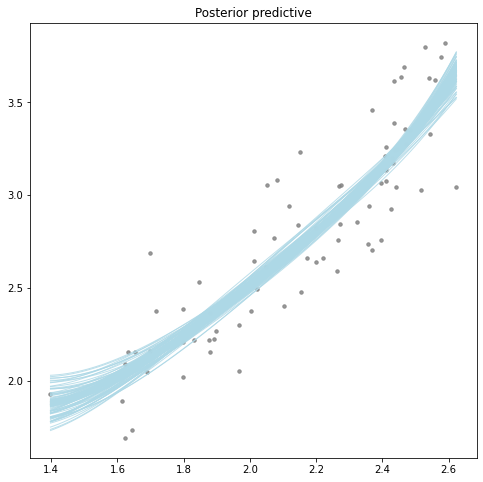

In [ ]:
# plot ordinary least square vs Bayesian
plt.figure(figsize = (8, 8))
pm.plot_posterior_predictive_glm(regression_trace_nodes_edges, samples = 100, eval=np.linspace(np.min(df.no_of_nodes), np.max(df.no_of_nodes), 100), linewidth = 1, 
                                 color = 'lightblue', alpha = 0.8, label = 'Bayesian Posterior Fits',
                                lm = lambda x, sample: sample['alpha'] + sample['beta'] * x +sample['gamma'] * x**2 + sample['delta'] * x**3 + sample['zeta'] * x**4)
plt.scatter(df['no_of_nodes'], df['no_of_edges'], s = 12, alpha = 0.8, c = 'gray', label = 'Observations')

In [ ]:
# log transformation of sampled nodes 
node_samples_transformed=np.log10(node_samples)
with regression_model_nodes_edges:
    pm.set_data({"nodes_values": np.array(node_samples_transformed).reshape(-1, 1)})
    posterior_predictive_nodes_edges = pm.sample_posterior_predictive(regression_trace_nodes_edges)

In [ ]:
#posterior_predictive_nodes_edges['Ylikelihood'].shape

In [ ]:
samples_nodes_edges=posterior_predictive_nodes_edges  

# select from different models
sample_no=random.sample(range(1000),k=100) 
samples_lst=[]
for x in range(100): 
  model_number = sample_no[x]
  model_value = samples_nodes_edges['Ylikelihood'][model_number][x]
  samples_lst.append(model_value[0])

full_prior_samples = pd.DataFrame(samples_lst, columns=['no_of_edges'])
full_prior_samples['no_of_nodes']=np.array(node_samples_transformed)
full_prior_samples=full_prior_samples.drop_duplicates().sort_values(by='no_of_nodes')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:2203: UserWarning: The marginal plotting function has changed to `histplot`, which does not accept the following argument(s): hist_kws.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


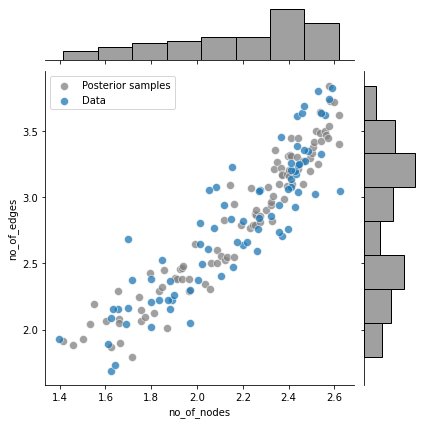

In [ ]:
def plot_density(samples):
    grid = sns.jointplot('no_of_nodes', 'no_of_edges', data=samples, color='gray', kind='scatter', height=6, 
                     joint_kws={'label': 'Posterior samples', 'alpha': .75, 's': 64},marginal_kws={'hist_kws': {'edgecolor': 'white'}})   
    sns.scatterplot('no_of_nodes', 'no_of_edges', data=df, ax=grid.ax_joint,s=64, alpha=.75, label='Data')   
    grid.ax_joint.legend(loc=0)
    return grid

plot_density(full_prior_samples)

In [ ]:
df_synthetic=full_prior_samples[['no_of_nodes','no_of_edges']]
df_synthetic=10**df_synthetic
df_synthetic['average_degree']=(df_synthetic['no_of_edges']*2)/(df_synthetic['no_of_nodes'])
df_synthetic=np.log10(df_synthetic)

In [ ]:
avg_clustering_values = df['average_clustering_coefficient'].values.reshape(-1, 1)

with pm.Model() as regression_model_degree_clustering:

    avg_degree_values = pm.Data("avg_degree_values", df['average_degree'].values.reshape(-1, 1))  

    alpha = pm.Normal('alpha', mu = -2.57778591, sd =.5)
    
    beta = pm.Normal('beta', mu = 8.67701697, sd = .5)
    gamma = pm.Normal('gamma', mu = -11.64685216, sd = .5)
    delta = pm.Normal('delta', mu = 6.97481184, sd = .5)
    zeta = pm.Normal('zeta', mu = -1.55689117, sd = .5)
    
    epsilon = pm.HalfNormal('epsilon', sd = 0.001)
    
    by_mean = alpha + beta * avg_degree_values + gamma * avg_degree_values**2 + delta * avg_degree_values**3 + zeta * avg_degree_values**4 
    
    Ylikelihood = pm.Normal('Ylikelihood', mu = by_mean, sd = epsilon, observed = avg_clustering_values)
    
    step = pm.NUTS()
    
    regression_trace_degree_clustering = pm.sample(1000, step, chains=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Sequential sampling (1 chains in 1 job)
NUTS: [epsilon, zeta, delta, gamma, beta, alpha]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 122 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


/usr/local/lib/python3.7/dist-packages/pymc3/plots/posteriorplot.py:62: DeprecationWarning: The `plot_posterior_predictive_glm` function will migrate to Arviz in a future release. 
Keep up to date with `ArviZ <https://arviz-devs.github.io/arviz/>`_ for future updates.
  DeprecationWarning,


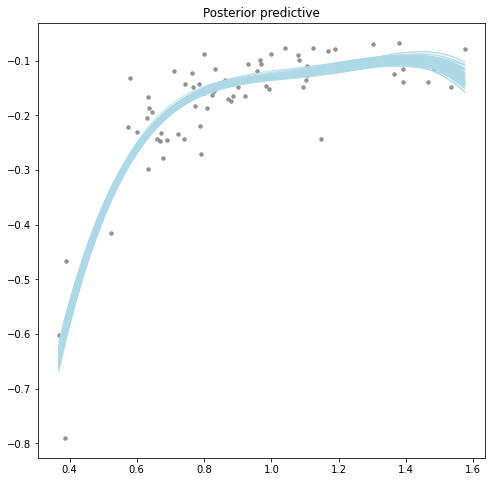

In [ ]:
plt.figure(figsize = (8, 8))
pm.plot_posterior_predictive_glm(regression_trace_degree_clustering, samples = 100, eval=np.linspace(np.min(df.average_degree), np.max(df.average_degree), 100), linewidth = 1, 
                                 color = 'lightblue', alpha = 0.8, label = 'Bayesian Posterior Fits',
                                lm = lambda x, sample: sample['alpha'] + sample['beta'] * x +sample['gamma'] * x**2 + sample['delta'] * x**3 + sample['zeta'] * x**4)
plt.scatter(df['average_degree'], df['average_clustering_coefficient'], s = 12, alpha = 0.8, c = 'gray', label = 'Observations')

In [ ]:
with regression_model_degree_clustering:
    pm.set_data({"avg_degree_values": df_synthetic['average_degree'].values.reshape(-1, 1)})
    posterior_predictive_degree_clustering = pm.sample_posterior_predictive(regression_trace_degree_clustering)

In [ ]:
samples_degree_clustering=posterior_predictive_degree_clustering

# select from different models
sample_no=random.sample(range(1000),k=100)
samples_lst=[]
for x in range(100):
  model_number = sample_no[x]
  model_value = samples_degree_clustering['Ylikelihood'][model_number][x]
  samples_lst.append(model_value[0])

full_prior_samples = pd.DataFrame(samples_lst, columns=['average_clustering_coefficient'])
full_prior_samples['average_degree']=df_synthetic.average_degree.values   
full_prior_samples=full_prior_samples.drop_duplicates().sort_values(by='average_degree')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:2203: UserWarning: The marginal plotting function has changed to `histplot`, which does not accept the following argument(s): hist_kws.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


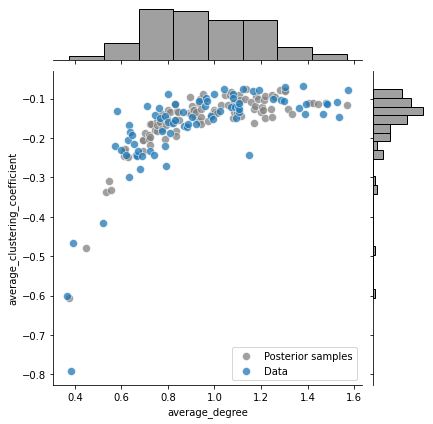

In [ ]:
def plot_density(samples):
    grid = sns.jointplot('average_degree', 'average_clustering_coefficient', data=samples, color='gray', kind='scatter', height=6, 
                     joint_kws={'label': 'Posterior samples', 'alpha': .75, 's': 64},marginal_kws={'hist_kws': {'edgecolor': 'white'}})   
    sns.scatterplot('average_degree', 'average_clustering_coefficient', data=df, ax=grid.ax_joint,s=64, alpha=.75, label='Data')   
    grid.ax_joint.legend(loc=0)
    return grid
plot_density(full_prior_samples)

In [ ]:
full_prior_samples=full_prior_samples.reset_index(drop=True)
df_synthetic=df_synthetic.sort_values(by='average_degree').reset_index(drop=True)
df_synthetic['average_clustering_coefficient']=full_prior_samples['average_clustering_coefficient']

In [ ]:
df_synthetic=10**df_synthetic
df_synthetic.no_of_nodes=df_synthetic.no_of_nodes.round(0)
df_synthetic.no_of_edges=df_synthetic.no_of_edges.round(0)
df_synthetic=df_synthetic.sort_values(by='no_of_nodes').reset_index(drop=True)


In [ ]:
df=data.iloc[:,[0,1,2,3,7,8,19]]
df=df.sort_values(by='average_degree').reset_index(drop=True)

In [ ]:
from scipy.stats import exponnorm
#fit
a, loc,scale = stats.exponnorm.fit(df.powerlaw_exponent)
# sample values
samples_powerlaw = exponnorm.rvs(a, loc,scale, size=100)  
df_synthetic['powerlaw_exponent'] = samples_powerlaw

In [ ]:
df_synthetic=df_synthetic.sort_values(by='no_of_nodes').reset_index(drop=True)
df=df.sort_values(by='no_of_nodes').reset_index(drop=True)

In [ ]:
from collections import Counter
from scipy import stats
def get_distribution(dist):
  # choose distribution
  if dist==1:
    lowerBound=0;upperBound=30
  elif dist==2:
    lowerBound=30;upperBound=50
  elif dist==3:
    lowerBound=50;upperBound=77
  dias=df.diameter[lowerBound:upperBound]
  counts=dict(Counter(dias))
  # find counts
  probabs_abs=[]
  lst=list(range(1,9))
  for value in lst:
    try:
      probabs_abs.append(counts[value])
    except:
      probabs_abs.append(0)
  # find probabilites
  probabs=[float(i)/sum(probabs_abs) for i in probabs_abs]
  discrete_dist = stats.rv_discrete(name='custm', values=(lst, probabs))
 
  return discrete_dist

In [ ]:
# get length of each groups
sample1_len = len(df_synthetic[df_synthetic.no_of_nodes<=df.no_of_nodes[30]])
sample2_len = len(df_synthetic[(df_synthetic.no_of_nodes>df.no_of_nodes[30]) & (df_synthetic.no_of_nodes<=df.no_of_nodes[50])])
sample3_len = len(df_synthetic[df_synthetic.no_of_nodes>df.no_of_nodes[50]])

In [ ]:
samples_dia1=get_distribution(1).rvs(size=sample1_len)
samples_dia2=get_distribution(2).rvs(size=sample2_len)
samples_dia3=get_distribution(3).rvs(size=sample3_len)

In [ ]:
dias_lst=list(samples_dia1)
dias_lst.extend(list(samples_dia2));dias_lst.extend(list(samples_dia3))
#dias_lst
df_synthetic['diameter']=dias_lst

In [ ]:
# getting radius
import math
df_synthetic['radius']=df_synthetic['diameter'].apply(lambda x: math.ceil(x/2))
rand_choice=random.choices([0,1], weights = [0.961,0.039], k = 100)        # weights based on given data 
df_synthetic['radius']=df_synthetic['radius']+rand_choice

In [22]:
df_synthetic=df_synthetic.sort_values(by='no_of_nodes').reset_index(drop=True)
df_synthetic=df_synthetic[['no_of_nodes','no_of_edges','average_degree','average_clustering_coefficient','diameter','radius','powerlaw_exponent']]
#df_synthetic.to_csv('data/Network_Metrics_synthetic_dataset2.csv')
df_synthetic


,no_of_nodes,no_of_edges,average_degree,average_clustering_coefficient,diameter,radius,powerlaw_exponent
0,26.0,81.0,6.238131,0.703321,3,2,2.407586
1,29.0,76.0,5.260353,0.633320,4,2,2.984418
2,32.0,85.0,5.349207,0.683539,3,2,2.365894
3,34.0,111.0,6.456137,0.732987,4,2,2.362633
4,36.0,156.0,8.758000,0.713908,7,4,3.267557
...,...,...,...,...,...,...,...
95,376.0,6951.0,36.987107,0.766860,5,3,2.778269
96,380.0,5278.0,27.781883,0.768408,4,2,2.982870
97,397.0,5258.0,26.504759,0.773142,4,2,2.143431
98,415.0,2500.0,12.031852,0.707582,4,2,3.425802


# Analysis of Synthetic data

In [23]:
a_file = open("data/Network_Metrics_real_dataset.pkl", "rb")
data = pickle.load(a_file)
data=data.drop(columns=['repo'])
df=data.iloc[:,[0,1,2,3,7,8,19]]
df=df.sort_values(by='no_of_nodes').reset_index(drop=True)

df_synthetic=pd.read_csv('data/Network_Metrics_synthetic_dataset.csv',index_col=0)
df_synthetic=df_synthetic.sort_values(by='no_of_nodes').reset_index(drop=True)

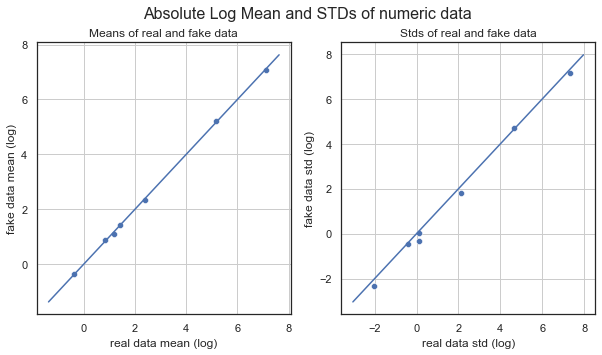

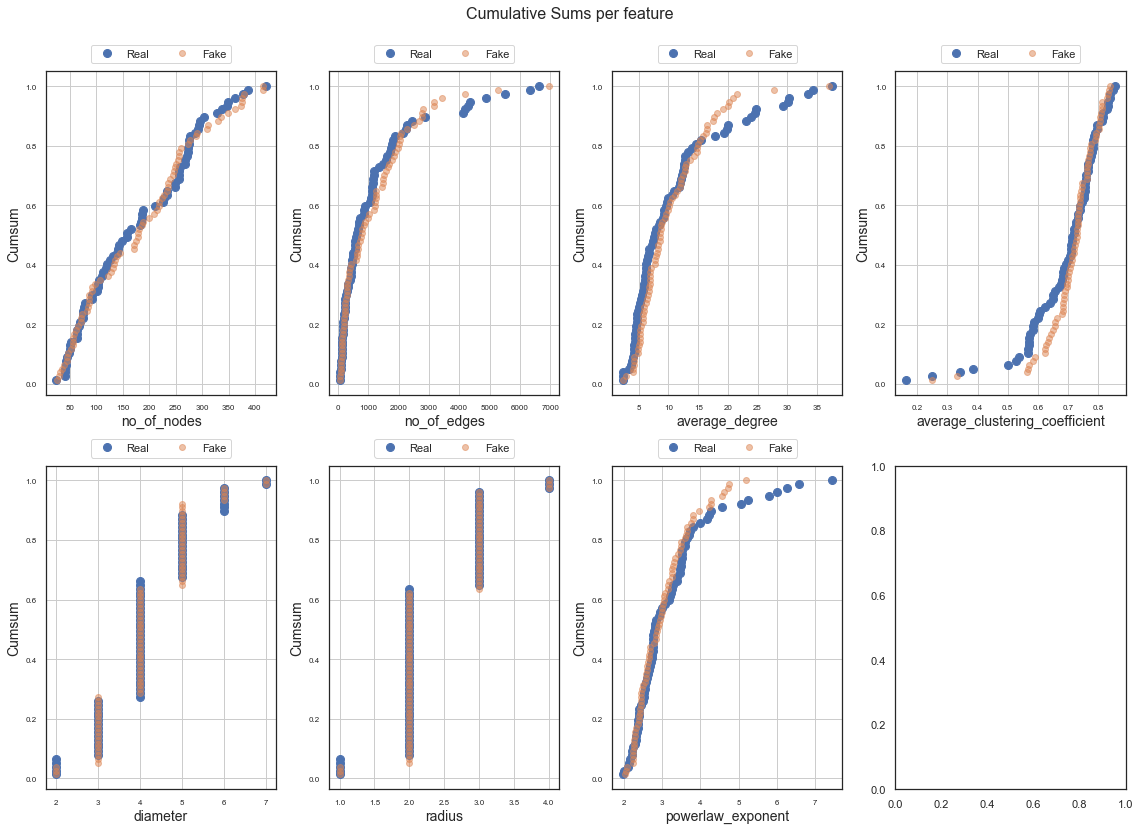

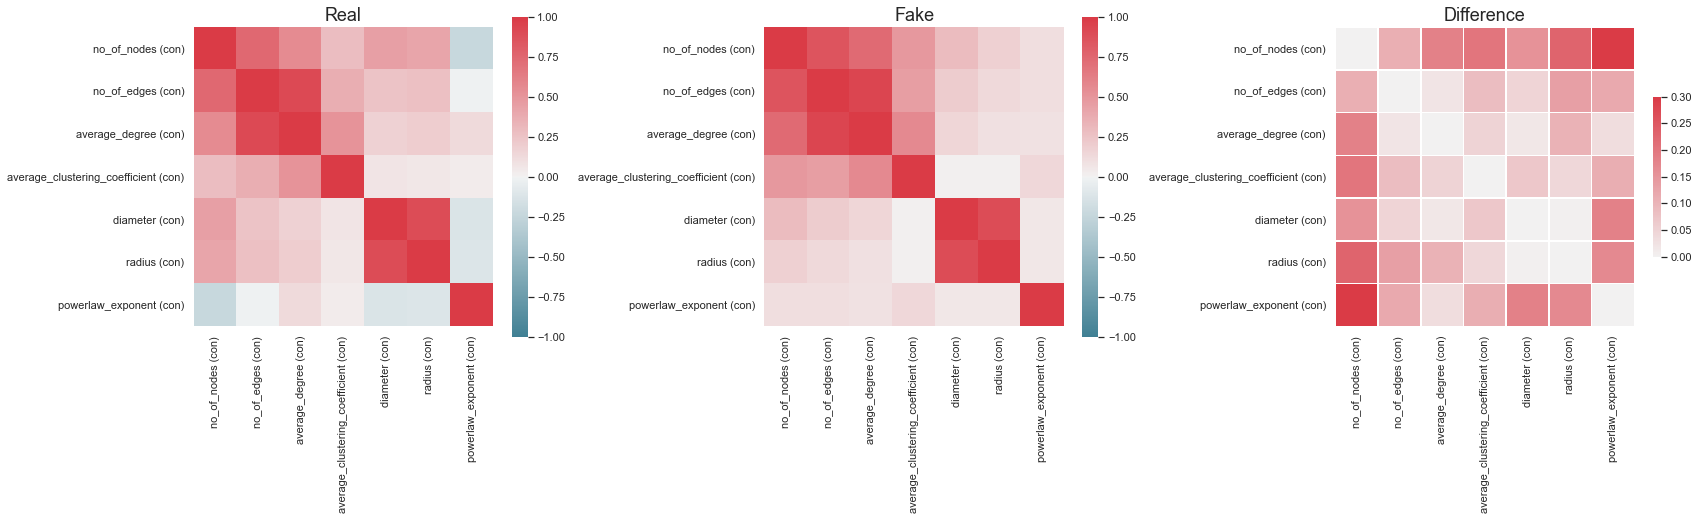

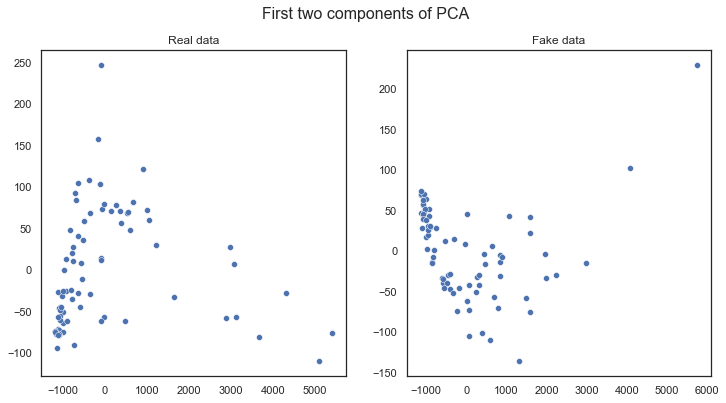

In [67]:
#!pip install table-evaluator
from table_evaluator import load_data, TableEvaluator
np.random.seed(29)
table_evaluator = TableEvaluator(df, df_synthetic)
#table_evaluator.visual_evaluation()
table_evaluator.plot_mean_std()
table_evaluator.plot_cumsums(nr_cols=4)
table_evaluator.plot_correlation_difference()
table_evaluator.plot_pca()
 

/Users/arslanzafar/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/arslanzafar/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


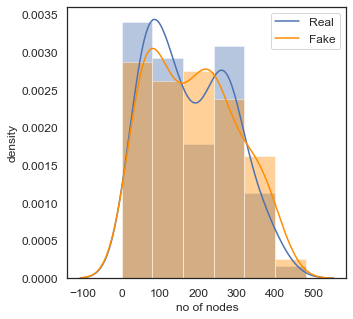

In [34]:
#nodes
plt.figure(figsize=(5,5))
sns.distplot(df.no_of_nodes,bins=range(0,500,80))
sns.distplot(df_synthetic.no_of_nodes,bins=range(0,500,80),color='darkorange')
plt.legend(['Real','Fake'],fontsize=12)
plt.xlabel('no of nodes', fontsize=12)
plt.ylabel('density', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

/Users/arslanzafar/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/arslanzafar/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


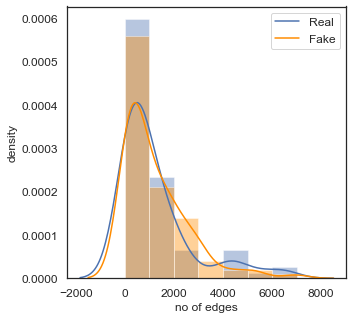

In [39]:
#edges
plt.figure(figsize=(5,5))
sns.distplot(df.no_of_edges,bins=range(0,8000,1000))      #fit=stats.beta
sns.distplot(df_synthetic.no_of_edges,bins=range(0,8000,1000),color='darkorange')      #fit=stats.beta
plt.legend(['Real','Fake'],fontsize=12)
plt.xlabel('no of edges', fontsize=12)
plt.ylabel('density', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

/Users/arslanzafar/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/arslanzafar/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


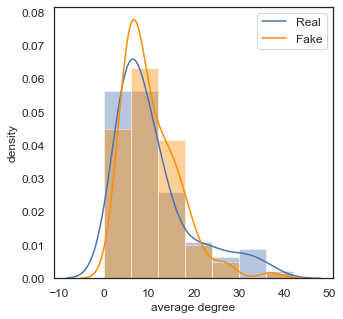

In [42]:
#averagedegree
plt.figure(figsize=(5,5))
sns.distplot(df.average_degree,bins=range(0,50,6))
sns.distplot(df_synthetic.average_degree,bins=range(0,50,6),color='darkorange')
plt.legend(['Real','Fake'],fontsize=12)
plt.xlabel('average degree', fontsize=12)
plt.ylabel('density', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

/Users/arslanzafar/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/arslanzafar/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


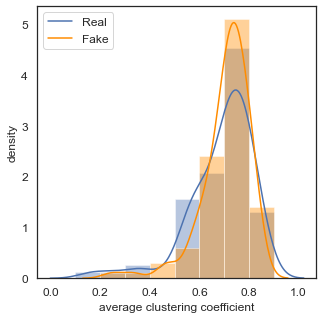

In [48]:
#avgCC
plt.figure(figsize=(5,5))
sns.distplot(df.average_clustering_coefficient,bins=np.arange(0,1.1,0.1))      
sns.distplot(df_synthetic.average_clustering_coefficient,bins=np.arange(0,1.1,0.1),color='darkorange') 
plt.legend(['Real','Fake'],fontsize=12)
plt.xlabel('average clustering coefficient', fontsize=12)
plt.ylabel('density', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

/Users/arslanzafar/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/arslanzafar/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


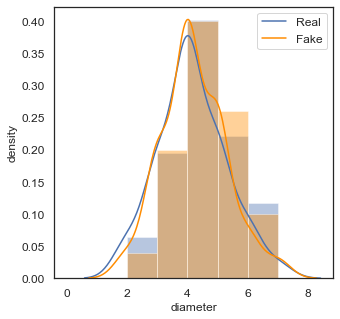

In [54]:
#diameter
plt.figure(figsize=(5,5))
sns.distplot(df.diameter,bins=np.arange(0,8,1))
sns.distplot(df_synthetic.diameter,bins=np.arange(0,8,1),color='darkorange')
plt.legend(['Real','Fake'],fontsize=12)
plt.xlabel('diameter', fontsize=12)
plt.ylabel('density', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

/Users/arslanzafar/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/arslanzafar/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


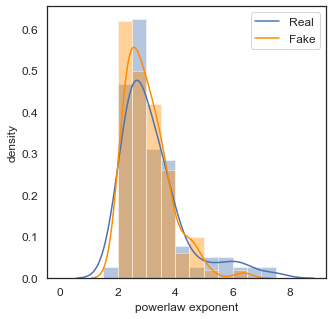

In [68]:
#powerlaw_exponent
plt.figure(figsize=(5,5))
sns.distplot(df.powerlaw_exponent,bins=np.arange(0,8,0.5))
sns.distplot(df_synthetic.powerlaw_exponent,color='darkorange',bins=np.arange(0,8,0.5))
plt.legend(['Real','Fake'],fontsize=12)
plt.xlabel('powerlaw exponent', fontsize=12)
plt.ylabel('density', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [73]:
%%capture

similarity_mean_std=0
similarity_mirror_column_associations=0
similarity_column_correlation=0
similarity_machine_learning_efficacy=0

iter_no=1000
for iter in range(iter_no):
    np.random.seed(iter)
    table_evaluator = TableEvaluator(df, df_synthetic)

    similarity_mean_std+=table_evaluator.statistical_evaluation()
    similarity_mirror_column_associations+=table_evaluator.correlation_correlation()
    similarity_column_correlation+=table_evaluator.column_correlations()   
    similarity_machine_learning_efficacy+=table_evaluator.estimator_evaluation(target_col='average_clustering_coefficient',target_type='regr')

def mean_absolute_percentage_error(y_true: np.ndarray, y_pred: np.ndarray):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))
pca_r = PCA(n_components=2)
pca_f = PCA(n_components=2)
real_t = pca_r.fit(df)
fake_t = pca_f.fit(df_synthetic)
results = pd.DataFrame({'real': np.log(real_t.explained_variance_), 'fake': np.log(fake_t.explained_variance_)})
pca_error = mean_absolute_percentage_error(np.log(real_t.explained_variance_), np.log(fake_t.explained_variance_))
similarity_pca_variance_correlation=1-pca_error

similarity_mean_std=similarity_mean_std/iter_no
similarity_mirror_column_associations=similarity_mirror_column_associations/iter_no
similarity_column_correlation=similarity_column_correlation/iter_no
similarity_machine_learning_efficacy=similarity_machine_learning_efficacy/iter_no


In [74]:
similarity_score=(similarity_mean_std+similarity_mirror_column_associations+similarity_column_correlation+similarity_pca_variance_correlation+similarity_machine_learning_efficacy)/5
print(similarity_score)

0.9144385259939799
